In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from data.aware_raw import AwareRaw, AwareSpectrogram
from data.cats_and_dogs import Dataset

dataset_raw = AwareRaw("data/AWARE_DATA_LABELS_2023-12-08_1611.csv", "data/id_map.csv", "data/aware_full_1704385505.db", pickle_file="data/aware_segmented.pkl")
dataset = AwareSpectrogram(dataset_raw, target_classes=[0,1])
# dataset.save_to_pickle('data/aware_spectrogram.pkl')

classes = [
    'Control / healthy / no pulmonary disease',
    'Asthma'
]
class_weights = compute_class_weight(
    'balanced', 
    classes=classes, 
    y=dataset.data['Participant:']
)
print("Class Weights:")
print(class_weights)

# dataset = Dataset("data/cats_and_dogs")

# class_weights = compute_class_weight(
#     'balanced', 
#     classes=[0,1], 
#     y=dataset.data['label']
# )
# print("Class Weights:")
# print(class_weights)

0it [00:00, ?it/s]

Class Weights:
[1.36956522 0.7875    ]


In [3]:
inputs, labels = dataset[0]
print(inputs.shape)
print(inputs.dtype)
print(inputs)

torch.Size([32, 3, 224, 224])
torch.float32
tensor([[[[0.4184, 0.4533, 0.5229,  ..., 0.5732, 0.5758, 0.5771],
          [0.4690, 0.4998, 0.5613,  ..., 0.5948, 0.5982, 0.5999],
          [0.5702, 0.5928, 0.6379,  ..., 0.6381, 0.6430, 0.6455],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.4184, 0.4533, 0.5229,  ..., 0.5732, 0.5758, 0.5771],
          [0.4690, 0.4998, 0.5613,  ..., 0.5948, 0.5982, 0.5999],
          [0.5702, 0.5928, 0.6379,  ..., 0.6381, 0.6430, 0.6455],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.4184, 0.4533, 0.5229,  ..., 0.5732, 0.5758, 0.5771],
          [0.4690, 0.4998, 0.5613,  ..., 0.5948, 0.5982, 0.5999]

Current device: cuda


Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


embeddings.cls_token
embeddings.position_embeddings
embeddings.patch_embeddings.projection.weight
embeddings.patch_embeddings.projection.bias
encoder.layer.0.attention.attention.query.weight
encoder.layer.0.attention.attention.query.bias
encoder.layer.0.attention.attention.key.weight
encoder.layer.0.attention.attention.key.bias
encoder.layer.0.attention.attention.value.weight
encoder.layer.0.attention.attention.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.layernorm_before.weight
encoder.layer.0.layernorm_before.bias
encoder.layer.0.layernorm_after.weight
encoder.layer.0.layernorm_after.bias
encoder.layer.1.attention.attention.query.weight
encoder.layer.1.attention.attention.query.bias
encoder.layer.1.attention.attention.key.weight
encoder.layer.1.attention.attention

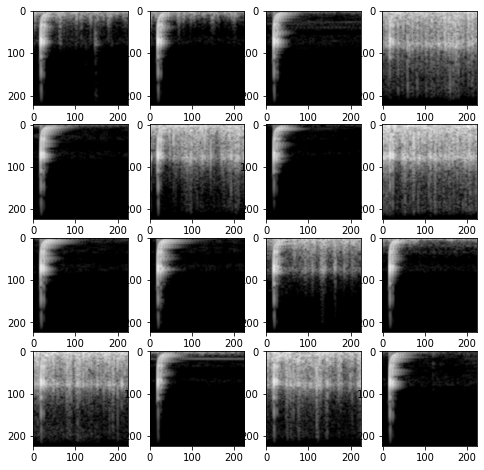

tensor([[-0.7621,  1.1445],
        [-0.9336,  1.2187],
        [-0.5564,  1.1129],
        [-0.7627,  0.8309],
        [-0.1302,  1.1450],
        [-0.7654,  0.6715],
        [-0.4616,  1.2133],
        [-0.7053,  0.7863],
        [-0.3477,  1.1115],
        [-0.3317,  1.1831],
        [-0.6469,  0.7666],
        [-0.8076,  1.2486],
        [-0.6807,  0.8221],
        [-0.5338,  1.1990],
        [-0.9448,  0.7685],
        [-0.3424,  1.2383]], device='cuda:0')
tensor([1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


In [7]:
import torch
import math
from transformers import VivitConfig, VivitImageProcessor, VivitForVideoClassification
from model.vivit import ViViT
import matplotlib.pyplot as plt
from matplotlib import animation

# RANDOM_SEED = [1,2,3,4,5,6,7,4399,114514,1234]
RANDOM_SEED = [1]
BATCH_SIZE = 16
LEARN_RATE = 0.25 # 0.005
MAX_NUM_EPOCH = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Current device:", device)

# image_processor = VivitImageProcessor(
#     do_resize = True,
#     do_rescale = False,
#     offset = False,
#     size = {'height':112, 'width':112},
#     crop_size = {'height':112, 'width':112},
#     image_mean = [0.5],
#     image_std = [0.5],
#     input_data_format = 'channels_last'
# )

config = VivitConfig(
    image_size = 112,
    num_frames = 50,
    num_channels = 1,
    num_attention_heads = 3,
    hidden_size = 192,
    num_labels = 2
) 
# model = VivitForVideoClassification(config)
model = ViViT(num_labels=2)
model.to(device)

plt.rcParams["animation.html"] = "jshtml"
def plot(inputs, animate=False):
    d = math.isqrt(inputs.shape[0]-1)+1
    fig, axs = plt.subplots(d, d, figsize=(8,8))
    im = []
    if inputs.shape[0]==1:
        im += axs.imshow(inputs[i,0,:,:,:].permute(1,2,0))
    else:
        for i in range(inputs.shape[0]):
            # im += [axs[i//d, i%d].pcolormesh(inputs[i,0,0,:,:], shading='gouraud', cmap='gray')]
            im += [axs[i//d, i%d].imshow(inputs[i,0,:,:,:].permute(1,2,0))]
    
    def update(frame):
        for i in range(inputs.shape[0]):
            im[i].set_array(inputs[i,frame,0,:,:])
        return tuple(im)
    
    if animate:
        ani = animation.FuncAnimation(fig=fig, func=update, frames=inputs.shape[1], interval=100)
        display(ani)
        plt.close(fig)
    else:
        plt.show()

data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
inputs, labels = next(iter(data_loader))
print(inputs.size())
plot(inputs, animate=False)

# inputs = image_processor(list(inputs.view(-1, *inputs.shape[2:])), return_tensors='pt')
# inputs['pixel_values'] = inputs['pixel_values'].view(BATCH_SIZE, -1, *inputs['pixel_values'].shape[2:])
# print(inputs['pixel_values'].size())
# plot(inputs['pixel_values'])

inputs = inputs.to(device)
with torch.no_grad():
    outputs = model(pixel_values=inputs)
predicted_label = outputs.argmax(-1)
print(outputs)
print(labels)
print(predicted_label)

In [5]:
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
import time
import jupyter_beeper

from data.aware_raw import AwareSplitter
from data.cats_and_dogs import Splitter
from trainer.spectrogram import Trainer
from utils.others import weight_reset, BasicMetrics, BasicOutputs
from utils.clustering import evaluate
from utils.outlier import novelty_detection

# metrics_cluster = np.zeros((5,3,3))
metrics_val = BasicMetrics()
metrics_test = BasicMetrics()
outputs_test = BasicOutputs()
ig_test = torch.Tensor([])

beeper = jupyter_beeper.Beeper()

for rand_seed in RANDOM_SEED:
    splitter = AwareSplitter(dataset, BATCH_SIZE, random_seed=rand_seed)

    timestr = time.strftime("%Y%m%d-%H%M%S")
    for split_idx, (train_loader, val_loader, test_loader) in enumerate(splitter):
        writer = SummaryWriter("runs/" + timestr + "-fold" + str(split_idx))
        model = ViViT(num_labels=2)
        model.to(device)
        
#         clear_output(wait=True)
        print("Seed " + str(rand_seed) + " | Fold #" + str(split_idx) + " | Training...")

        trainer = Trainer(
            model,
            lr = LEARN_RATE,
            T_max = MAX_NUM_EPOCH,
            device = device,
            summarywriter = writer,
            class_weights = torch.Tensor(class_weights)
        )
        
        for epoch in tqdm(range(MAX_NUM_EPOCH), unit_scale=True, unit="epoch"):
            trainer.train(epoch, train_loader)
            trainer.validate(epoch, val_loader)
        print("Validataion:")
        trainer.test(val_loader, no_print=False)
        metrics_val.append_from(trainer)
        print("Test:")
        trainer.test(test_loader, no_print=False, calculate_ig=False)
        metrics_test.append_from(trainer)
        outputs_test.append_from(trainer)
        # ig_test = torch.concat((ig_test, trainer.attr_ig), dim=0)
        print()

#     beeper.beep(frequency=600, secs=0.5)
#     novelty_detection(model, train_loader, val_loader, test_loader)
#     metrics_cluster[split_idx,:,:] = evaluate(model, train_loader, val_loader, test_loader)    

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Seed 1 | Fold #0 | Training...


  0%|          | 0.00/50.0 [00:00<?, ?epoch/s]

KeyboardInterrupt: 

In [ ]:
print(ig_test.size())
print("Final Validation Results")
display(metrics_val)
print()
print("Final Test Results")
display(metrics_test)
print()
beeper.beep(frequency=600, secs=0.5)